#### SEE V1 in folder for all the lab specific questions and executive summary.
#### This document is focused on developing additional analysis and scoring for 3rd party subreddits
##### v3 will be totally stripped down for export and focus on supporting my blog post - how political is your subreddit

In [79]:
import pandas as pd
import numpy as np
import scipy as sp
import requests
import json
import time
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Getting and exploring Democrat and republican information
#Using the same cell to do the pulls to save some space

In [24]:
data_list = []
URL = "https://www.reddit.com/r/Republican/.json"
#seems to be a cap at 20
for step in range(20):
    res = requests.get(URL, headers={'User-agent': 'Conor Barry Bot 0.1'})
    data = res.json()
    
    for i in range(len(data['data']['children'])):
        temp = {}
        temp['subreddit'] = data['data']['children'][i]['data']['subreddit_name_prefixed'].replace('r/', '')
        temp['title']=data['data']['children'][i]['data']['title']
        temp['selftext'] = data['data']['children'][i]['data']['selftext']
        data_list.append(temp)

    new_after = data['data']['after']
    URL = "https://www.reddit.com/r/Republican/.json?after=" + new_after
    print('    iteration {} worked. URL: {}'.format(step, URL))
    time.sleep(3)
    
df_republicans_scrape = pd.DataFrame(data_list)
print('    size: ', df_republicans_scrape.shape)
df_republicans_scrape.head()

    iteration 0 worked. URL: https://www.reddit.com/r/Republican/.json?after=t3_9bpt7f
    iteration 1 worked. URL: https://www.reddit.com/r/Republican/.json?after=t3_9b6mn7
    iteration 2 worked. URL: https://www.reddit.com/r/Republican/.json?after=t3_9acujw
    iteration 3 worked. URL: https://www.reddit.com/r/Republican/.json?after=t3_99x53j
    iteration 4 worked. URL: https://www.reddit.com/r/Republican/.json?after=t3_99bxdv
    iteration 5 worked. URL: https://www.reddit.com/r/Republican/.json?after=t3_97zicr
    iteration 6 worked. URL: https://www.reddit.com/r/Republican/.json?after=t3_97y95a
    iteration 7 worked. URL: https://www.reddit.com/r/Republican/.json?after=t3_96zirr
    iteration 8 worked. URL: https://www.reddit.com/r/Republican/.json?after=t3_96axws
    iteration 9 worked. URL: https://www.reddit.com/r/Republican/.json?after=t3_95ocui
    iteration 10 worked. URL: https://www.reddit.com/r/Republican/.json?after=t3_95cjo7
    iteration 11 worked. URL: https://www.

,selftext,subreddit,title
0,,Republican,"How Socialism Rots The Soul, The Culture And T..."
1,,Republican,Florida primary 2018: A look at Central Florid...
2,,Republican,POOF HE’S GONE! MSNBC and ABC crop out Louis F...
3,,Republican,Neocons and liberals hate Trump because he has...
4,,Republican,John McCain's marriage was like a Hallmark Cha...


### Save your results as a CSV
You may do this regularly while scraping data as well, so that if your scraper stops of your computer crashes, you don't lose all your data.

In [25]:
# Export to csv
df_republicans_scrape.to_csv('./Data/InitialRepublicanPosts_9_03.csv', index=False)

In [3]:
#Pick up CSVs after recorded. Dems First
df_dems_init = pd.read_csv('./Data/InitialDemocratsPosts_8_31.csv')
df_dems_new = pd.read_csv('./Data/InitialDemocratsPosts_9_03.csv')

In [4]:
#Seems like we need to drop first row as duplicate.Probably a locked post. Otherwise good. 
(df_dems_init.loc[:,['selftext', 'title']]==df_dems_new.loc[:,['selftext', 'title']]).sum()

selftext    1
title       1
dtype: int64

In [5]:
df_democrats_all = df_dems_init.append(df_dems_new.iloc[1:, ], ignore_index=True)

In [6]:
#Pick up CSVs after recorded. Now Reps
df_reps_init = pd.read_csv('./Data/InitialRepublicanPosts.csv')
df_reps_new = pd.read_csv('./Data/InitialRepublicanPosts_9_03.csv')

In [7]:
#No overlaps
(df_reps_init.loc[:,['selftext', 'title']]==df_reps_new.loc[:,['selftext', 'title']]).sum()

selftext    0
title       0
dtype: int64

In [8]:
df_republicans_all = df_reps_init.append(df_reps_new, ignore_index=True)

In [9]:
df_init_DemRep = df_democrats_all.append(df_republicans_all, ignore_index=True, verify_integrity=True)
df_init_DemRep.shape

(2001, 3)

In [10]:
#Value counts check out. Looks like we got an extra Dem post from that locked post.
df_init_DemRep['subreddit'].value_counts()

democrats     1001
Republican    1000
Name: subreddit, dtype: int64

In [11]:
mask={
    'democrats':1, 
    'Republican':0
}
df_init_DemRep['subreddit'].map(mask)
df_init_DemRep.fillna(' ', inplace=True)
df_init_DemRep.isnull().sum()

selftext     0
subreddit    0
title        0
dtype: int64

In [12]:
#Filling this in for later application to new subs, if I get to it
#Figures as of 8/30/2018
dem_subscribers = 66.2 #Thousand
reb_subscribers = 52.4 #Thousand
dem_prior = dem_subscribers / (dem_subscribers + reb_subscribers)
rep_prior = 1 - dem_prior
dem_prior

0.5581787521079259

In [13]:
#Loosely correlates to 2016 presidential election number of 51%
#Lower Figure here jives with qualitative assumption that reddit leans democrat a little more

#### Conor's Gameplan

1. Get Dems, repubs into single frame
    1a. Convert data
    1b. Temporarily downselect titles only
2. Run logit
3. Answer basic questions
4. Create separate title vector (with word_ format for feature names) for each
5. Collect these together to one mega frame and re-rune
6. Synthesize Democrat / Republican-ness

#### SEE V1 in folder for all the lab specific questions and executive summary.
#### This document is focused on developing additional analysis and scoring for 3rd party subreddits
##### Which is the focus of my intended blog post.

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import stop_words
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns

In [15]:
my_stop_words = stop_words.ENGLISH_STOP_WORDS

In [16]:
#90% of self text is blank. 
df_init_DemRep[df_init_DemRep['selftext']==' '].count()[0]

1876

In [17]:
#no compelling reason to pull in self-text
df_data = df_init_DemRep.loc[:, ['subreddit', 'title']]

In [18]:
def fit_transform_model(X=df_data.title, y=df_data.subreddit, 
                        vecmod='TFID', pred='logreg', 
                        test_size_local=None, random_state_local=42 ):
    """I absolutely created this function after running through the lab the first time. 
    I figured that it would help me clean up the rest of the document, as well as making
    additions to the model.
    With a little bit of work, this should be very generalizable to future models for me."""
    
    #get vectorizer
    if vecmod == 'TFID':
        vecmod_ = TfidfVectorizer(stop_words=my_stop_words, ngram_range=(1,3))
    else:
        vecmod_ = vecmod
    
    #TTS, 
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=test_size_local, 
                                                        random_state=random_state_local)
    X_train_transform = vecmod_.fit_transform(X_train).todense()
    df_X_train_transform = pd.DataFrame(X_train_transform, columns=vecmod_.get_feature_names())
    X_test_transform = vecmod_.transform(X_test).todense()
    df_X_test_transform = pd.DataFrame(X_test_transform, columns=vecmod_.get_feature_names())
    
    #predict model
    if pred == 'logreg':
        funct_model_= LogisticRegression()
    else:
        funct_model_ = pred
        
    funct_model_.fit(df_X_train_transform, y_train)
    
    #Export features and scores
    global latest_model, latest_transform, sorted_d, train_x, test_x, test_y, train_y
    latest_model = funct_model_ 
    train_x, test_x, train_y, test_y = df_X_train_transform, df_X_test_transform, y_train, y_test
    latest_transform = vecmod_
    
    try:
        feature_values =(dict(zip(list(df_X_train_transform.columns), list(funct_model_.coef_[0]))))
        sorted_d = sorted((value, key) for (key,value) in feature_values.items())
    except:
        return funct_model_.score(df_X_test_transform, y_test)
    
    return funct_model_.score(df_X_test_transform, y_test)

In [19]:
fit_transform_model(test_size_local=.2)

0.9226932668329177

In [102]:
#This got a lot better with more data

In [20]:
print('   republican indicators:')
for i in range(10):
    print('    ', sorted_d[i])
#print('    democratic indicators: ', sorted_d[:-10])
print('\n    democratic indicators:')
for i in range(10):
    print('    ', sorted_d[-i-1])

   republican indicators:
     (-1.044754467779082, 'liberals')
     (-0.8221478000274467, 'left')
     (-0.8172386177966948, 'walkaway')
     (-0.8139598050951399, 'brennan')
     (-0.8072737169713672, 'socialism')
     (-0.8047598629235031, 'media')
     (-0.7638735443251032, 'hc')
     (-0.7282312815300432, 'like')
     (-0.7148407058800351, 'work')
     (-0.6888763936317656, 'mean')

    democratic indicators:
     (2.8039010312647354, 'trump')
     (1.9514814129704061, 'president')
     (1.8794800247649253, 'mccain')
     (1.5912581579177456, 'kavanaugh')
     (1.34712065016521, 'rourke')
     (1.258439546742597, 'beto')
     (1.176195779364775, 'beto rourke')
     (1.1480866258680207, 'twitter')
     (1.0710938306145288, 'say')
     (1.0162109449509296, 'white house')


#### Note to self: Clean out higher of one and to word combos?

In [21]:
cm = confusion_matrix(test_y, latest_model.predict(test_x))
df_cm = pd.DataFrame(cm, columns=['Predicted Repub', 'Pred Dem'], index=['Actual Rep', 'Actual Dem'])
df_cm

,Predicted Repub,Pred Dem
Actual Rep,183,16
Actual Dem,15,187


#### Refit using binary features

In [22]:
fit_transform_model(test_size_local=.2, vecmod=TfidfVectorizer(stop_words=my_stop_words,
                                           ngram_range = (1,3), 
                                           binary=True))

0.9201995012468828

Answer: Pretty much the same.

## Predicting subreddit using Random Forests + Another Classifier

#### Nothing added by keeping this subsection in here.
For the most part, the models still did not outperform the base model. RFC was slightly better, but it does not have the explanatory features I want for my purposes. 

In [23]:
from sklearn.ensemble import RandomForestClassifier

In [24]:
fit_transform_model(pred=RandomForestClassifier())

0.8243512974051896

In [25]:
fit_transform_model(test_size_local=.2)

0.9226932668329177

In [26]:
#RandomForest is slightly better, but harder to explain. Sticking with logit. 

# Executive Summary
---
### The Need

YOU are a totally legitimate campaign strategy group (and not at all a nefarious foreign entity).     

YOU **NEED** to expand your voter turnout numbers by identifying low-key voters who would support you, but eschew venues by which you would normally reach out to them (e.g. Facebook).   
  
YOU are smart and cautious, having seen how a misplaced ad or statement can be easily twisted to support the other side, and want to make sure your ads are interpreted as intended.
  
 So where are these voters?? How do you mine them and find them without stepping on mines?
 
 ### The solution
 Introducing **The HUAC 9000**   
 
 Named for the infamous and (occaisionally) successful communist hunting committee of the 1950s, the HUAC 9000 uses data from thousands of known Democratic and Republican posts to ferret out party-line sentiment hidden under benign cat-posts.   
   
The HUAC 9000 can identify party leanings and the strength of those leanings in an easy to interpret score, saving you time and precious resources by increasing the effectiveness of ads. 
  
  
### We can do it
Our team has years of cumulative experience getting blind-sided by uncomfortable political conversations that seem to erupt out of nowhere. Exasperated that it was becoming impossible to talk about anything nice for more than 5 minutes, our team (consisting of top 50 Kaggle scoreres in the Ames Iowa competition and codewars veterans rank 5 or higher) spent uncountable hours fine-tuning the HUAC. 
  
  
### Now is the Time
Our team of trained experts will stand up a HUAC 9000 implementation tuned to your candidate, and teach you to search Reddit to find your supporters. No one is looking over your shoulder ;), meaning you have more time to focus on what matters.  
  
  
If they can vote for Laurel or Yonny, they can vote for your candidate. Don't let them get away - buy HUAC 9000 Today.


## Collection of Executive Summary information
Includes final model refit.

In [27]:
#!pip install wordcloud

In [28]:
#https://www.geeksforgeeks.org/generating-word-cloud-python/

In [29]:
from wordcloud import WordCloud

In [108]:
fit_transform_model(test_size_local=.2, vecmod=TfidfVectorizer(stop_words=my_stop_words,
                                           ngram_range = (1,3), 
                                           binary=False))

0.9226932668329177

In [116]:
cm = confusion_matrix(test_y, latest_model.predict(test_x))
df_cm = pd.DataFrame(cm, columns=['Predicted Repub', 'Pred Dem'], index=['Actual Rep', 'Actual Dem'])
df_cm

,Predicted Repub,Pred Dem
Actual Rep,183,16
Actual Dem,15,187


In [109]:
rep_word_dict = dict(sorted_d[:21])
dem_word_dict = dict(sorted(sorted_d[-20:], reverse=True))

In [110]:
dem_word_dict

{2.8039010312647354: 'trump',
 1.9514814129704061: 'president',
 1.8794800247649253: 'mccain',
 1.5912581579177456: 'kavanaugh',
 1.34712065016521: 'rourke',
 1.258439546742597: 'beto',
 1.176195779364775: 'beto rourke',
 1.1480866258680207: 'twitter',
 1.0710938306145288: 'say',
 1.0162109449509296: 'white house',
 0.937351924595669: 'republicans',
 0.8892119021517713: 'cohen',
 0.8647760074178018: 'plan',
 0.8572657057773955: 'democrats',
 0.8400660588456147: 'gillum',
 0.8054940653067043: 'administration',
 0.7784924318650955: 'presidency',
 0.7741454825825453: 'donald',
 0.7729584393830872: 'corruption',
 0.7692271545631377: 'white'}

In [33]:
len(rep_word_dict)

20

In [34]:
from math import exp
import random

In [111]:
rep_word_dict_trans = {}
for key in rep_word_dict.keys():
    new_key_= int(exp(-key)*2000) #watch out for this negative
    while new_key_ in rep_word_dict.keys():
        new_key_+=1 #tie breaker prevents override of values
        print('    ',new_key_)
    rep_word_dict_trans[new_key_] = rep_word_dict[key]
rep_words_str = ''
for key in rep_word_dict_trans.keys():
    rep_words_str = rep_words_str + key*(str(rep_word_dict_trans[key]) + ' ')

In [112]:
dem_word_dict_trans = {}
for key in dem_word_dict.keys():
    new_key_= int(exp(key)*2000)
    while new_key_ in dem_word_dict.keys():
        new_key_+=1
        print('    ',new_key_)
    dem_word_dict_trans[new_key_] = dem_word_dict[key]
dem_words_str = ''
for key in dem_word_dict_trans.keys():
    dem_words_str = dem_words_str + key*(str(dem_word_dict_trans[key]) + ' ')
dem_word_dict_trans

{33017: 'trump',
 14078: 'president',
 13100: 'mccain',
 9819: 'kavanaugh',
 7692: 'rourke',
 7039: 'beto',
 6484: 'beto rourke',
 6304: 'twitter',
 5837: 'say',
 5525: 'white house',
 5106: 'republicans',
 4866: 'cohen',
 4748: 'plan',
 4713: 'democrats',
 4633: 'gillum',
 4475: 'administration',
 4356: 'presidency',
 4337: 'donald',
 4332: 'corruption',
 4316: 'white'}

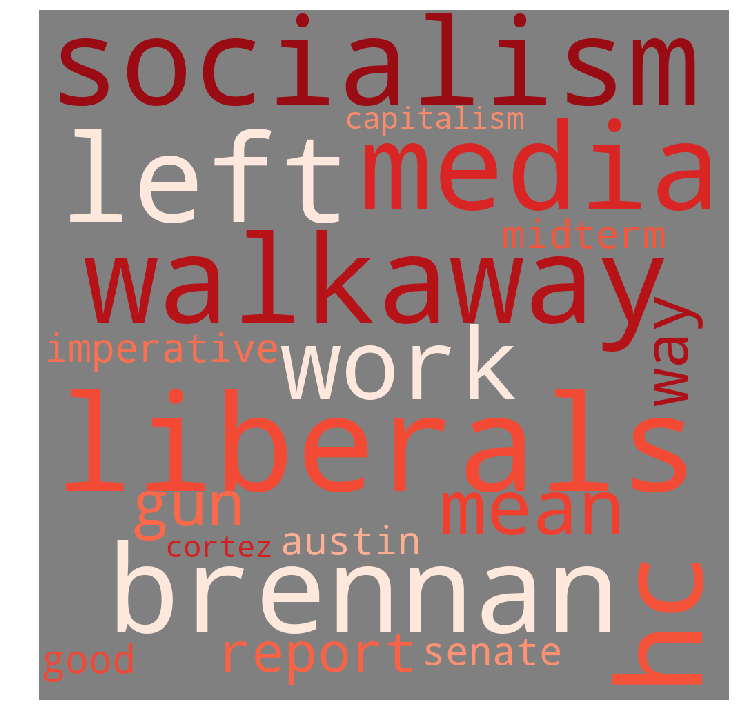

In [118]:
mycloud = WordCloud(width=1000, height=1000,
                    background_color='grey', 
                    colormap='Reds',
                    min_font_size=1,
                    max_words=len(rep_words_str),
                    collocations=False, #get rid of duplicates
                   normalize_plurals=False).generate_from_text(rep_words_str)
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(mycloud)
plt.axis("off")
plt.tight_layout(pad = 0)
mycloud.to_file('./Presentation/OutputFigs/RepCloud_2.png')

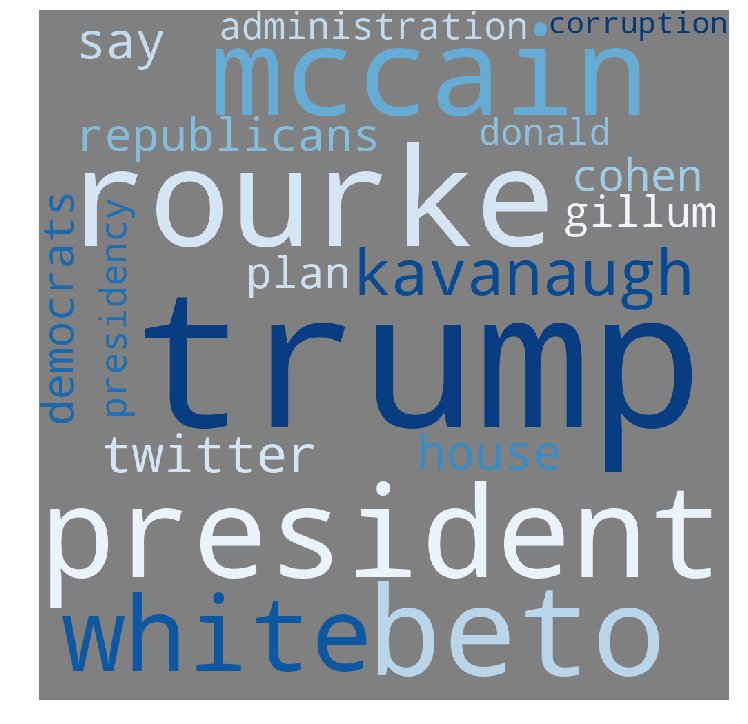

In [119]:
mycloud = WordCloud(width=1000, height=1000,
                    background_color='grey', 
                    min_font_size=1,
                    colormap='Blues',
                    collocations=False, #get rid of duplicates
                   normalize_plurals=False,
                   max_words=len(dem_words_str)).generate_from_text(dem_words_str)
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(mycloud)
plt.axis("off")
plt.tight_layout(pad = 0)
mycloud.to_file('./Presentation/OutputFigs/DemCloud_2.png')

In [ ]:
#Talk about overlap - words more tightly clustered for republican/

In [113]:
all_rep_words = { key:dict(sorted_d)[key] for key in dict(sorted_d).keys() if key>0 }
all_dem_words = { key:dict(sorted_d)[key] for key in dict(sorted_d).keys() if key<0 }
print('   demwords:', len(all_dem_words))
print('   repwords:', len(all_rep_words))
print('   ', len(all_rep_words)+len(all_dem_words))

   demwords: 1356
   repwords: 1708
    3064


In [114]:
results_list = []
for i in range(50,100, 5):
    j = i/100
    temp_dict = {}
    temp_dict['strength'] = j
    temp_dict['dem_words'] = len([key for key in dict(sorted_d).keys() if key>j])
    temp_dict['rep_words'] = len([key for key in dict(sorted_d).keys() if key<-j])
    results_list.append(temp_dict)
    


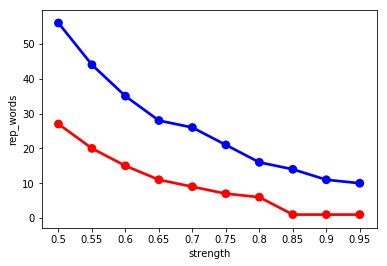

In [39]:
#Democrats talk about more things
df_stregnths = pd.DataFrame(results_list)
sns.pointplot('strength','dem_words', data=df_stregnths, color='b')
sns.pointplot('strength','rep_words', data=df_stregnths, color='r')

In [40]:
#compare predict probas
probas = latest_model.predict_proba(test_x)
dem_probs = []
rep_probs = []
for i in range(len(probas)):
    if probas[i][0] >.5:
        rep_probs.append(1-probas[i][0])
    else:
        dem_probs.append(probas[i][1])

In [41]:
print('    average dem score: ', sum(dem_probs) / len(dem_probs))
print('    average rep score: ', sum(rep_probs) / len(rep_probs))

    average dem score:  0.6227361226649912
    average rep score:  0.3846176009029235


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


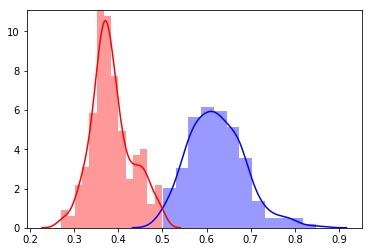

In [42]:
#Distribution of republican and Democrat strength scoring
sns.distplot(dem_probs, label='dem', color='blue') 
sns.distplot(rep_probs, label='rep', color='red')

In [43]:
'''
Interpretation: Republicans talk about fewer things, but those things are big indicators. Maybe it takes a higher number of keywords to trigger Dem prediction?
For the purposes of applying this to a random subreddit, 
we want scores outside [.38 to .62], to be safe'''

'\nInterpretation: Republicans talk about fewer things, but those things are big indicators. Maybe it takes a higher number of keywords to trigger Dem prediction?\nFor the purposes of applying this to a random subreddit, \nwe want scores outside [.38 to .62], to be safe'

   net:  -4.139435759544119
   mean:  -0.0103227824427534


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


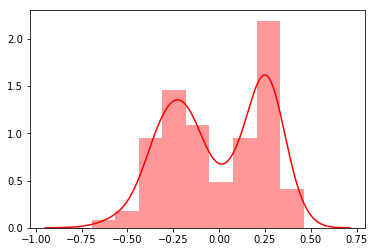

In [115]:
probas = latest_model.predict_proba(test_x)
net_probs = []
for i in range(len(probas)):
    net_probs.append(probas[i][0] - probas[i][1]) #R minus D so that Republican == positive, 

sns.distplot(net_probs, label='rep', color='red')
print('   net: ', sum(net_probs))
print('   mean: ', np.average(net_probs))

### Which posts were the most?

In [45]:
df_checker = pd.DataFrame(pd.Series(test_y))

In [46]:
df_checker['rep_score'] = [probas[i][0] for i in range(len(probas))]
df_checker['dem_score'] = [probas[i][1] for i in range(len(probas))]

In [47]:
#Most republican post
df_checker[df_checker['rep_score']==df_checker['rep_score'].max()]

,subreddit,rep_score,dem_score
1867,Republican,0.730722,0.269278


In [48]:
#Most democratic post
df_checker[df_checker['dem_score']==df_checker['dem_score'].max()]

,subreddit,rep_score,dem_score
239,democrats,0.151878,0.848122


In [49]:
#The most democratic thing you could suggest right now:
#df_init_DemRep.iloc[96:97, :] no selftext...
df_init_DemRep['title'][239]

'R.I.P. McCain'

In [50]:
#The most Republican thing you could suggest right now:
#df_init_DemRep.iloc[987:988, :]no selftext...
df_init_DemRep['title'][1867]

'U S Senate Candidate, Austin Petersen, on his Bid to Represent MO'

# Outside Testing
---
Getting scores and validation from 3rd and 4th subreddit. 

In [51]:
from scipy.stats import ttest_1samp

## Outside Testing: The_Donald


In [132]:
data_list = []
base_url = "https://www.reddit.com/r/The_Donald/.json"
URL = base_url
#seems to be a cap at 20
for step in range(20):
    res = requests.get(URL, headers={'User-agent': 'Conor Barry Bot 0.1'})
    data = res.json()
    
    for i in range(len(data['data']['children'])):
        temp = {}
        temp['subreddit'] = data['data']['children'][i]['data']['subreddit_name_prefixed'].replace('r/', '')
        temp['title']=data['data']['children'][i]['data']['title']
        temp['selftext'] = data['data']['children'][i]['data']['selftext']
        data_list.append(temp)

    new_after = data['data']['after']
    URL = base_url + "?after=" + new_after
    print('    iteration {} worked. URL: {}'.format(step, URL))
    time.sleep(3)
    
df_donald_scrape = pd.DataFrame(data_list)
print('    size: ', df_donald_scrape.shape)
# Export to csv
df_donald_scrape.to_csv('./Data/TheDonaldPosts_9_03_A.csv', index=False)
df_donald_scrape.head()

    iteration 0 worked. URL: https://www.reddit.com/r/The_Donald/.json?after=t3_9coezc
    iteration 1 worked. URL: https://www.reddit.com/r/The_Donald/.json?after=t3_9cly58
    iteration 2 worked. URL: https://www.reddit.com/r/The_Donald/.json?after=t3_9cmdzg
    iteration 3 worked. URL: https://www.reddit.com/r/The_Donald/.json?after=t3_9cpm1d
    iteration 4 worked. URL: https://www.reddit.com/r/The_Donald/.json?after=t3_9cpbu3
    iteration 5 worked. URL: https://www.reddit.com/r/The_Donald/.json?after=t3_9ckq7m
    iteration 6 worked. URL: https://www.reddit.com/r/The_Donald/.json?after=t3_9cpqvs
    iteration 7 worked. URL: https://www.reddit.com/r/The_Donald/.json?after=t3_9clac8
    iteration 8 worked. URL: https://www.reddit.com/r/The_Donald/.json?after=t3_9cgzae
    iteration 9 worked. URL: https://www.reddit.com/r/The_Donald/.json?after=t3_9coctc
    iteration 10 worked. URL: https://www.reddit.com/r/The_Donald/.json?after=t3_9cnzb3
    iteration 11 worked. URL: https://www.

,selftext,subreddit,title
0,,The_Donald,GEOTUS calls out President Bashar Al-Assad of ...
1,,The_Donald,Afghan asylum seeker is jailed for eight years...
2,,The_Donald,"I see that John Kerry, the father of the now t..."
3,,The_Donald,He could have kept to his billionaire lifestyl...
4,,The_Donald,Blue Wave 2018- Ben Garrison cartoon! Beach Cl...


In [103]:
#Jump into analysis for this subreddit here from here
df_data_current = pd.read_csv('./Data/TheDonaldPosts_9_03_A.csv').loc[:, ['title']]
X_cur = latest_transform.transform(df_data_current.title).todense()
df_cur_predictions = pd.DataFrame(latest_model.predict(X_cur),
                                 columns=['Party'])
mask = {
    'democrats': 1,
    'Republican': 0
}
df_cur_predictions = pd.DataFrame(df_cur_predictions['Party'].map(mask), columns=['Party'])
df_cur_predictions = df_cur_predictions.join(pd.DataFrame(latest_model.predict_proba(X_cur), columns = ['rep_score', 'dem_score'] ))

In [104]:
#Average score - <.5 means republican
df_cur_predictions['Party'].mean()

0.448207171314741

In [105]:
(df_cur_predictions['Party'].mean() - rep_prior) / rep_prior

0.014453635838326269

    average dem score:  0.5768999974879451
    average rep score:  0.4415937219592944
    net score:  -52


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


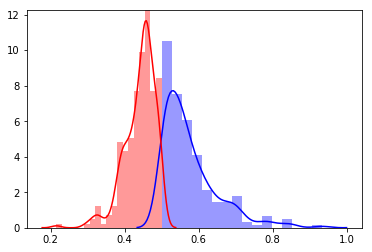

In [106]:
probas = latest_model.predict_proba(X_cur)
min_prob = .5
dem_probs = []
rep_probs = []
for i in range(len(probas)):
    if probas[i][0] >min_prob:
        rep_probs.append(1-probas[i][0])
    elif probas[i][1]>min_prob:
        dem_probs.append(probas[i][1])
print('    average dem score: ', sum(dem_probs) / len(dem_probs))
print('    average rep score: ', sum(rep_probs) / len(rep_probs))

print('    net score: ', len(dem_probs) -len(rep_probs) )
#Distribution of republican and Democrat strength scoring
sns.distplot(dem_probs, label='dem', color='blue') 
sns.distplot(rep_probs, label='rep', color='red')
plt.savefig('./Presentation/OutputFigs/DonaldComparison.png')

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


   net:  -2.247920835024381
   mean:  -0.004477929950247767


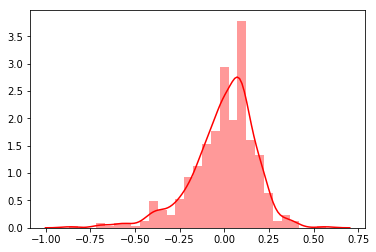

In [107]:
probas = latest_model.predict_proba(X_cur)
net_probs = []
for i in range(len(probas)):
    net_probs.append(probas[i][0] - probas[i][1]) #R minus D so that Republican == positive, 

sns.distplot(net_probs, label='rep', color='red')
print('   net: ', sum(net_probs))
print('   mean: ', np.average(net_probs))
plt.savefig('./Presentation/OutputFigs/DonaldNet.png')

## Outside Testing: cats


In [193]:
data_list = []
base_url = "https://www.reddit.com/r/cats/.json"
URL = base_url
#seems to be a cap at 20
for step in range(20):
    res = requests.get(URL, headers={'User-agent': 'Conor Barry Bot 0.1'})
    data = res.json()
    
    for i in range(len(data['data']['children'])):
        temp = {}
        temp['subreddit'] = data['data']['children'][i]['data']['subreddit_name_prefixed'].replace('r/', '')
        temp['title']=data['data']['children'][i]['data']['title']
        temp['selftext'] = data['data']['children'][i]['data']['selftext']
        data_list.append(temp)

    new_after = data['data']['after']
    URL = base_url + "?after=" + new_after
    print('    iteration {} worked. URL: {}'.format(step, URL))
    time.sleep(3)
    
df_cats_scrape = pd.DataFrame(data_list)
print('    size: ', df_cats_scrape.shape)
# Export to csv
df_cats_scrape.to_csv('./Data/catsPosts_9_03_A.csv', index=False)
df_cats_scrape.head()

    iteration 0 worked. URL: https://www.reddit.com/r/cats/.json?after=t3_9cn1v8
    iteration 1 worked. URL: https://www.reddit.com/r/cats/.json?after=t3_9cn8tt
    iteration 2 worked. URL: https://www.reddit.com/r/cats/.json?after=t3_9couf1
    iteration 3 worked. URL: https://www.reddit.com/r/cats/.json?after=t3_9ckwel
    iteration 4 worked. URL: https://www.reddit.com/r/cats/.json?after=t3_9cq5p6
    iteration 5 worked. URL: https://www.reddit.com/r/cats/.json?after=t3_9cpxx4
    iteration 6 worked. URL: https://www.reddit.com/r/cats/.json?after=t3_9cmraq
    iteration 7 worked. URL: https://www.reddit.com/r/cats/.json?after=t3_9cmu8z
    iteration 8 worked. URL: https://www.reddit.com/r/cats/.json?after=t3_9cpozs
    iteration 9 worked. URL: https://www.reddit.com/r/cats/.json?after=t3_9clleo
    iteration 10 worked. URL: https://www.reddit.com/r/cats/.json?after=t3_9cpfky
    iteration 11 worked. URL: https://www.reddit.com/r/cats/.json?after=t3_9cn3e8
    iteration 12 worked. U

,selftext,subreddit,title
0,,cats,We got Ruth from a rescue centre. She follows ...
1,,cats,"She’s been gone four months, but I still miss ..."
2,,cats,"After a long battle with kidney disease, Squea..."
3,,cats,16 Year Old Bookmark
4,,cats,"He hates being held, but today he actually cli..."


In [82]:
df_data_current = pd.read_csv('./Data/catsPosts_9_03_A.csv').loc[:, ['title']]
X_cur = latest_transform.transform(df_data_current.title).todense()
df_cur_predictions = pd.DataFrame(latest_model.predict(X_cur),
                                 columns=['Party'])
mask = {
    'democrats': 1,
    'Republican': 0
}
df_cur_predictions = pd.DataFrame(df_cur_predictions['Party'].map(mask), columns=['Party'])
df_cur_predictions = df_cur_predictions.join(pd.DataFrame(latest_model.predict_proba(X_cur), columns = ['rep_score', 'dem_score'] ))

In [83]:
#Average score - <.5 means republican
df_cur_predictions['Party'].mean()

0.234

In [84]:
(df_cur_predictions['Party'].mean() - rep_prior) / rep_prior

-0.4703740458015266

    average dem score:  0.5412800837091407
    average rep score:  0.45083541264055965
    net score:  -266


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


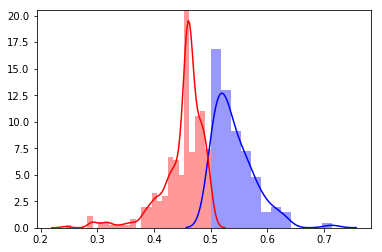

In [69]:
probas = latest_model.predict_proba(X_cur)
min_prob = .5
dem_probs = []
rep_probs = []
for i in range(len(probas)):
    if probas[i][0] >min_prob:
        rep_probs.append(1-probas[i][0])
    elif probas[i][1]>min_prob:
        dem_probs.append(probas[i][1])
print('    average dem score: ', sum(dem_probs) / len(dem_probs))
print('    average rep score: ', sum(rep_probs) / len(rep_probs))

print('    net score: ', len(dem_probs) -len(rep_probs) )
#Distribution of republican and Democrat strength scoring
sns.distplot(dem_probs, label='dem', color='blue') 
sns.distplot(rep_probs, label='rep', color='red')
plt.savefig('./Presentation/OutputFigs/catsComparison.png')

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


   net:  28.00053432939172
   mean:  0.056001068658783404


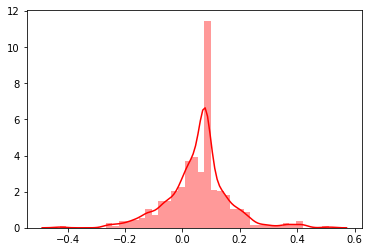

In [85]:
probas = latest_model.predict_proba(X_cur)
net_probs = []
for i in range(len(probas)):
    net_probs.append(probas[i][0] - probas[i][1]) #R minus D so that Republican == positive, 

sns.distplot(net_probs, label='rep', color='red')
print('   net: ', sum(net_probs))
print('   mean: ', np.average(net_probs))
plt.savefig('./Presentation/OutputFigs/catsNet.png')

## Outside Testing: dogs


In [198]:
data_list = []
base_url = "https://www.reddit.com/r/dogs/.json"
URL = base_url
#seems to be a cap at 20
for step in range(20):
    res = requests.get(URL, headers={'User-agent': 'Conor Barry Bot 0.1'})
    data = res.json()
    
    for i in range(len(data['data']['children'])):
        temp = {}
        temp['subreddit'] = data['data']['children'][i]['data']['subreddit_name_prefixed'].replace('r/', '')
        temp['title']=data['data']['children'][i]['data']['title']
        temp['selftext'] = data['data']['children'][i]['data']['selftext']
        data_list.append(temp)

    new_after = data['data']['after']
    URL = base_url + "?after=" + new_after
    print('    iteration {} worked. URL: {}'.format(step, URL))
    time.sleep(3)
    
df_dogs_scrape = pd.DataFrame(data_list)
print('    size: ', df_dogs_scrape.shape)
# Export to csv
df_dogs_scrape.to_csv('./Data/dogsPosts_9_03_A.csv', index=False)
df_dogs_scrape.head()

    iteration 0 worked. URL: https://www.reddit.com/r/dogs/.json?after=t3_9cq4rj
    iteration 1 worked. URL: https://www.reddit.com/r/dogs/.json?after=t3_9cdkbj
    iteration 2 worked. URL: https://www.reddit.com/r/dogs/.json?after=t3_9ch3f8
    iteration 3 worked. URL: https://www.reddit.com/r/dogs/.json?after=t3_9cdqv8
    iteration 4 worked. URL: https://www.reddit.com/r/dogs/.json?after=t3_9cc9xc
    iteration 5 worked. URL: https://www.reddit.com/r/dogs/.json?after=t3_9c79yo
    iteration 6 worked. URL: https://www.reddit.com/r/dogs/.json?after=t3_9c7y7z
    iteration 7 worked. URL: https://www.reddit.com/r/dogs/.json?after=t3_9c35rl
    iteration 8 worked. URL: https://www.reddit.com/r/dogs/.json?after=t3_9btyjs
    iteration 9 worked. URL: https://www.reddit.com/r/dogs/.json?after=t3_9c01fp
    iteration 10 worked. URL: https://www.reddit.com/r/dogs/.json?after=t3_9bqjzl
    iteration 11 worked. URL: https://www.reddit.com/r/dogs/.json?after=t3_9bqj4z
    iteration 12 worked. U

,selftext,subreddit,title
0,"Dogs working because they love us, because we ...",dogs,[Photo Friday] A Labor of Love
1,"For the September Trick of the Month, we’ll be...",dogs,[Discussion] Trick of the Month - September 20...
2,"Ok, she's actually a great dog; troublemaker m...",dogs,[Fluff] My energetic troublemaker made me prou...
3,I was told he's a Pitt/Lab mix and he looks li...,dogs,[FLUFF] Every time someone asks what breed my ...
4,I came to his subreddit asking to learn about ...,dogs,[Discussion] Sometimes you do everything “righ...


In [71]:
df_data_current = pd.read_csv('./Data/dogsPosts_9_03_A.csv').loc[:, ['title']]
X_cur = latest_transform.transform(df_data_current.title).todense()
df_cur_predictions = pd.DataFrame(latest_model.predict(X_cur),
                                 columns=['Party'])
mask = {
    'democrats': 1,
    'Republican': 0
}
df_cur_predictions = pd.DataFrame(df_cur_predictions['Party'].map(mask), columns=['Party'])
df_cur_predictions = df_cur_predictions.join(pd.DataFrame(latest_model.predict_proba(X_cur), columns = ['rep_score', 'dem_score'] ))

In [72]:
#Average score - <.5 means republican
df_cur_predictions['Party'].mean()

0.5537848605577689

In [73]:
(df_cur_predictions['Party'].mean() - dem_prior) / dem_prior

-0.007871835919163472

    average dem score:  0.5535483157532352
    average rep score:  0.46651164878686907
    net score:  54


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


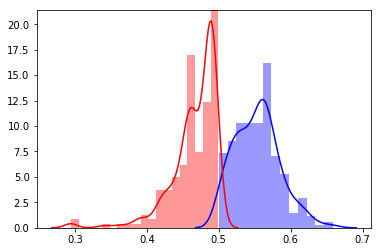

In [74]:
probas = latest_model.predict_proba(X_cur)
min_prob = .5
dem_probs = []
rep_probs = []
for i in range(len(probas)):
    if probas[i][0] >min_prob:
        rep_probs.append(1-probas[i][0])
    elif probas[i][1]>min_prob:
        dem_probs.append(probas[i][1])
print('    average dem score: ', sum(dem_probs) / len(dem_probs))
print('    average rep score: ', sum(rep_probs) / len(rep_probs))

print('    net score: ', len(dem_probs) -len(rep_probs) )
#Distribution of republican and Democrat strength scoring
sns.distplot(dem_probs, label='dem', color='blue') 
sns.distplot(rep_probs, label='rep', color='red')
plt.savefig('./Presentation/OutputFigs/dogsComparison.png')

   net:  -14.77008221531569
   net:  -0.029422474532501335


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


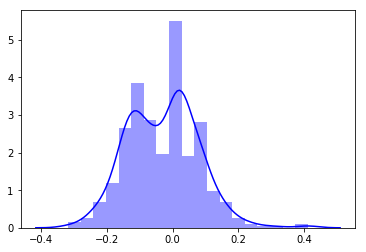

In [81]:
probas = latest_model.predict_proba(X_cur)
net_probs = []
for i in range(len(probas)):
    net_probs.append(probas[i][0] - probas[i][1]) #R minus D so that Republican == positive, 

sns.distplot(net_probs, label='rep', color='blue')
print('   net: ', sum(net_probs))
print('   net: ', np.average(net_probs))
plt.savefig('./Presentation/OutputFigs/DogsNet.png')

## Outside Testing: Communism


In [205]:
data_list = []
base_url = "https://www.reddit.com/r/communism/.json"
URL = base_url
#seems to be a cap at 20
for step in range(20):
    res = requests.get(URL, headers={'User-agent': 'Conor Barry Bot 0.1'})
    data = res.json()
    
    for i in range(len(data['data']['children'])):
        temp = {}
        temp['subreddit'] = data['data']['children'][i]['data']['subreddit_name_prefixed'].replace('r/', '')
        temp['title']=data['data']['children'][i]['data']['title']
        temp['selftext'] = data['data']['children'][i]['data']['selftext']
        data_list.append(temp)

    new_after = data['data']['after']
    URL = base_url + "?after=" + new_after
    print('    iteration {} worked. URL: {}'.format(step, URL))
    time.sleep(3)
    
df_communism_scrape = pd.DataFrame(data_list)
print('    size: ', df_communism_scrape.shape)
# Export to csv
df_communism_scrape.to_csv('./Data/communismPosts_9_03_A.csv', index=False)
df_communism_scrape.head()

    iteration 0 worked. URL: https://www.reddit.com/r/communism/.json?after=t3_9ceees
    iteration 1 worked. URL: https://www.reddit.com/r/communism/.json?after=t3_9bnga9
    iteration 2 worked. URL: https://www.reddit.com/r/communism/.json?after=t3_9amdqk
    iteration 3 worked. URL: https://www.reddit.com/r/communism/.json?after=t3_99ygtk
    iteration 4 worked. URL: https://www.reddit.com/r/communism/.json?after=t3_99bfol
    iteration 5 worked. URL: https://www.reddit.com/r/communism/.json?after=t3_98dsl8
    iteration 6 worked. URL: https://www.reddit.com/r/communism/.json?after=t3_97l9f8
    iteration 7 worked. URL: https://www.reddit.com/r/communism/.json?after=t3_9745gs
    iteration 8 worked. URL: https://www.reddit.com/r/communism/.json?after=t3_969lij
    iteration 9 worked. URL: https://www.reddit.com/r/communism/.json?after=t3_95pjau
    iteration 10 worked. URL: https://www.reddit.com/r/communism/.json?after=t3_95093m
    iteration 11 worked. URL: https://www.reddit.com/

,selftext,subreddit,title
0,,communism,The use of the buzzword “National Security” is...
1,,communism,China announces huge debt relief program for c...
2,,communism,Israel drafts a law to jail anybody flying Pal...
3,,communism,EXPOSED! 'Nazi' Azov Battalion receives Armame...
4,,communism,Indian Farmers &amp; Industrial Workers to Hol...


In [86]:
df_data_current = pd.read_csv('./Data/communismPosts_9_03_A.csv').loc[:, ['title']]
X_cur = latest_transform.transform(df_data_current.title).todense()
df_cur_predictions = pd.DataFrame(latest_model.predict(X_cur),
                                 columns=['Party'])
mask = {
    'democrats': 1,
    'Republican': 0
}
df_cur_predictions = pd.DataFrame(df_cur_predictions['Party'].map(mask), columns=['Party'])
df_cur_predictions = df_cur_predictions.join(pd.DataFrame(latest_model.predict_proba(X_cur), columns = ['rep_score', 'dem_score'] ))

In [87]:
#Average score - <.5 means republican
df_cur_predictions['Party'].mean()

0.268

In [88]:
(df_cur_predictions['Party'].mean() - dem_prior) / dem_prior

-0.5198670694864049

    average dem score:  0.5455317505942349
    average rep score:  0.43550140999869374
    net score:  -232


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


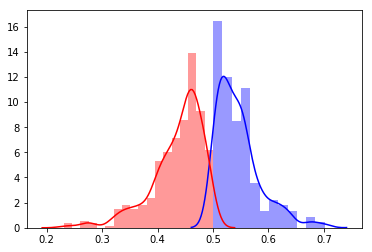

In [33]:
probas = latest_model.predict_proba(X_cur)
min_prob = .5
dem_probs = []
rep_probs = []
for i in range(len(probas)):
    if probas[i][0] >min_prob:
        rep_probs.append(1-probas[i][0])
    elif probas[i][1]>min_prob:
        dem_probs.append(probas[i][1])
print('    average dem score: ', sum(dem_probs) / len(dem_probs))
print('    average rep score: ', sum(rep_probs) / len(rep_probs))

print('    net score: ', len(dem_probs) -len(rep_probs) )
#Distribution of republican and Democrat strength scoring

sns.distplot(dem_probs, label='dem', color='blue') 
sns.distplot(rep_probs, label='rep', color='red')
plt.savefig('./Presentation/OutputFigs/communismComparison.png')

In [34]:
print('   definitive dems: {}\n   definitive repubs: {}\n   per.dem:{}\n   per.rep{} '.format(
     len(dem_probs), 
     len(rep_probs), 
     len(dem_probs)/ (len(dem_probs) + len(rep_probs)),
     len(rep_probs)/ (len(dem_probs) + len(rep_probs))
))

   definitive dems: 134
   definitive repubs: 366
   per.dem:0.268
   per.rep0.732 


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


   net:  35.01045872170067
   net:  0.07002091744340133


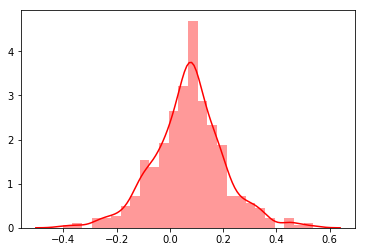

In [89]:
probas = latest_model.predict_proba(X_cur)
net_probs = []
for i in range(len(probas)):
    net_probs.append(probas[i][0] - probas[i][1]) #R minus D so that Republican == positive, 

sns.distplot(net_probs, label='rep', color='red')
print('   net: ', sum(net_probs))
print('   net: ', np.average(net_probs))
plt.savefig('./Presentation/OutputFigs/CommunistsNet.png')

Ttest_1sampResult(statistic=26.947607813373754, pvalue=3.1475315814315307e-72)

## Outside Testing: All


In [96]:
data_list = []
base_url = "https://www.reddit.com/r/all/.json"
URL = base_url
#seems to be a cap at 20
for step in range(20):
    res = requests.get(URL, headers={'User-agent': 'Conor Barry Bot 0.1'})
    data = res.json()
    
    for i in range(len(data['data']['children'])):
        temp = {}
        temp['subreddit'] = data['data']['children'][i]['data']['subreddit_name_prefixed'].replace('r/', '')
        temp['title']=data['data']['children'][i]['data']['title']
        temp['selftext'] = data['data']['children'][i]['data']['selftext']
        data_list.append(temp)

    new_after = data['data']['after']
    URL = base_url + "?after=" + new_after
    print('    iteration {} worked. URL: {}'.format(step, URL))
    time.sleep(3)
    
df_all_scrape = pd.DataFrame(data_list)
print('    size: ', df_hbb_scrape.shape)
# Export to csv
df_all_scrape.to_csv('./Data/allPosts_9_04_A.csv', index=False)
df_all_scrape.head()

    iteration 0 worked. URL: https://www.reddit.com/r/all/.json?after=t3_9cu3jb
    iteration 1 worked. URL: https://www.reddit.com/r/all/.json?after=t3_9cv3fp
    iteration 2 worked. URL: https://www.reddit.com/r/all/.json?after=t3_9cuubb
    iteration 3 worked. URL: https://www.reddit.com/r/all/.json?after=t3_9cuoyl
    iteration 4 worked. URL: https://www.reddit.com/r/all/.json?after=t3_9cttk3
    iteration 5 worked. URL: https://www.reddit.com/r/all/.json?after=t3_9crpsw
    iteration 6 worked. URL: https://www.reddit.com/r/all/.json?after=t3_9cuywt
    iteration 7 worked. URL: https://www.reddit.com/r/all/.json?after=t3_9cvhpa
    iteration 8 worked. URL: https://www.reddit.com/r/all/.json?after=t3_9cu5ii
    iteration 9 worked. URL: https://www.reddit.com/r/all/.json?after=t3_9cuzql
    iteration 10 worked. URL: https://www.reddit.com/r/all/.json?after=t3_9cvsdo
    iteration 11 worked. URL: https://www.reddit.com/r/all/.json?after=t3_9ctxog
    iteration 12 worked. URL: https://

,selftext,subreddit,title
0,,comics,Immortality
1,,sports,Sidecar co-pilots hugging the corners at the S...
2,,worldnews,The EU and national funders launch a plan to m...
3,,pics,My Grandpa turned 100 last week. He stayed up ...
4,,coolguides,"And this folks, is how gerrymandering works"


In [97]:
df_data_current = pd.read_csv('./Data/allPosts_9_04_A.csv').loc[:, ['title']]
X_cur = latest_transform.transform(df_data_current.title).todense()
df_cur_predictions = pd.DataFrame(latest_model.predict(X_cur),
                                 columns=['Party'])
mask = {
    'democrats': 1,
    'Republican': 0
}
df_cur_predictions = pd.DataFrame(df_cur_predictions['Party'].map(mask), columns=['Party'])
df_cur_predictions = df_cur_predictions.join(pd.DataFrame(latest_model.predict_proba(X_cur), columns = ['rep_score', 'dem_score'] ))

In [98]:
#Average score - <.5 means republican
df_cur_predictions['Party'].mean()

0.238

In [99]:
(df_cur_predictions['Party'].mean() - dem_prior) / dem_prior

-0.5736132930513596

    average dem score:  0.5521704733217355
    average rep score:  0.44517315341156427
    net score:  -262


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


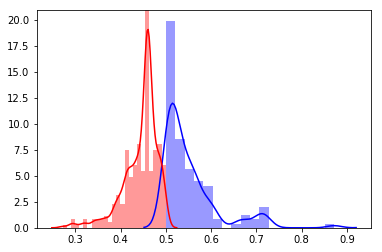

In [100]:
probas = latest_model.predict_proba(X_cur)
min_prob = .5
dem_probs = []
rep_probs = []
for i in range(len(probas)):
    if probas[i][0] >min_prob:
        rep_probs.append(1-probas[i][0])
    elif probas[i][1]>min_prob:
        dem_probs.append(probas[i][1])
print('    average dem score: ', sum(dem_probs) / len(dem_probs))
print('    average rep score: ', sum(rep_probs) / len(rep_probs))

print('    net score: ', len(dem_probs) -len(rep_probs) )
#Distribution of republican and Democrat strength scoring

sns.distplot(dem_probs, label='dem', color='blue') 
sns.distplot(rep_probs, label='rep', color='red')
plt.savefig('./Presentation/OutputFigs/hbbComparison.png')

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


   net:  29.36148444981454
   net:  0.058722968899629066


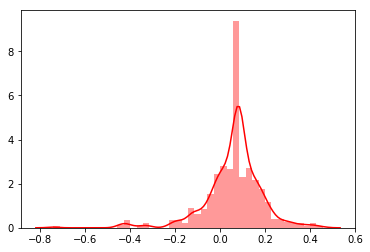

In [101]:
probas = latest_model.predict_proba(X_cur)
net_probs = []
for i in range(len(probas)):
    net_probs.append(probas[i][0] - probas[i][1]) #R minus D so that Republican == positive, 

sns.distplot(net_probs, label='rep', color='red')
print('   net: ', sum(net_probs))
print('   net: ', np.average(net_probs))
plt.savefig('./Presentation/OutputFigs/hbbNet.png')

In [102]:
dem_prior

0.5581787521079259